In [5]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import joblib

In [6]:
df = pd.read_csv(r"C:\Users\Acer\Desktop\BMW\BMW_Car_Sales_Classification.csv")
pd.set_option('display.max_columns', None)
df

,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low
...,...,...,...,...,...,...,...,...,...,...,...
49995,i3,2014,Asia,Red,Hybrid,Manual,4.6,151030,42932,8182,High
49996,i3,2023,Middle East,Silver,Electric,Manual,4.2,147396,48714,9816,High
49997,5 Series,2010,Middle East,Red,Petrol,Automatic,4.5,174939,46126,8280,High
49998,i3,2020,Asia,White,Electric,Automatic,3.8,3379,58566,9486,High


In [7]:
df.describe()

,Year,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2017.015700,3.247180,100307.203140,75034.600900,5067.514680
std,4.324459,1.009078,57941.509344,25998.248882,2856.767125
min,2010.000000,1.500000,3.000000,30000.000000,100.000000
25%,2013.000000,2.400000,50178.000000,52434.750000,2588.000000
50%,2017.000000,3.200000,100388.500000,75011.500000,5087.000000
75%,2021.000000,4.100000,150630.250000,97628.250000,7537.250000
max,2024.000000,5.000000,199996.000000,119998.000000,9999.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model                 50000 non-null  object 
 1   Year                  50000 non-null  int64  
 2   Region                50000 non-null  object 
 3   Color                 50000 non-null  object 
 4   Fuel_Type             50000 non-null  object 
 5   Transmission          50000 non-null  object 
 6   Engine_Size_L         50000 non-null  float64
 7   Mileage_KM            50000 non-null  int64  
 8   Price_USD             50000 non-null  int64  
 9   Sales_Volume          50000 non-null  int64  
 10  Sales_Classification  50000 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 4.2+ MB


In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
numeric_cols = ['Year', 'Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume']
categorical_cols = ['Model', 'Region', 'Color', 'Fuel_Type', 'Transmission']

In [11]:
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median()[0], inplace=True)


for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

In [12]:
target_counts = df['Sales_Classification'].value_counts()
target_counts

Sales_Classification
Low     34754
High    15246
Name: count, dtype: int64

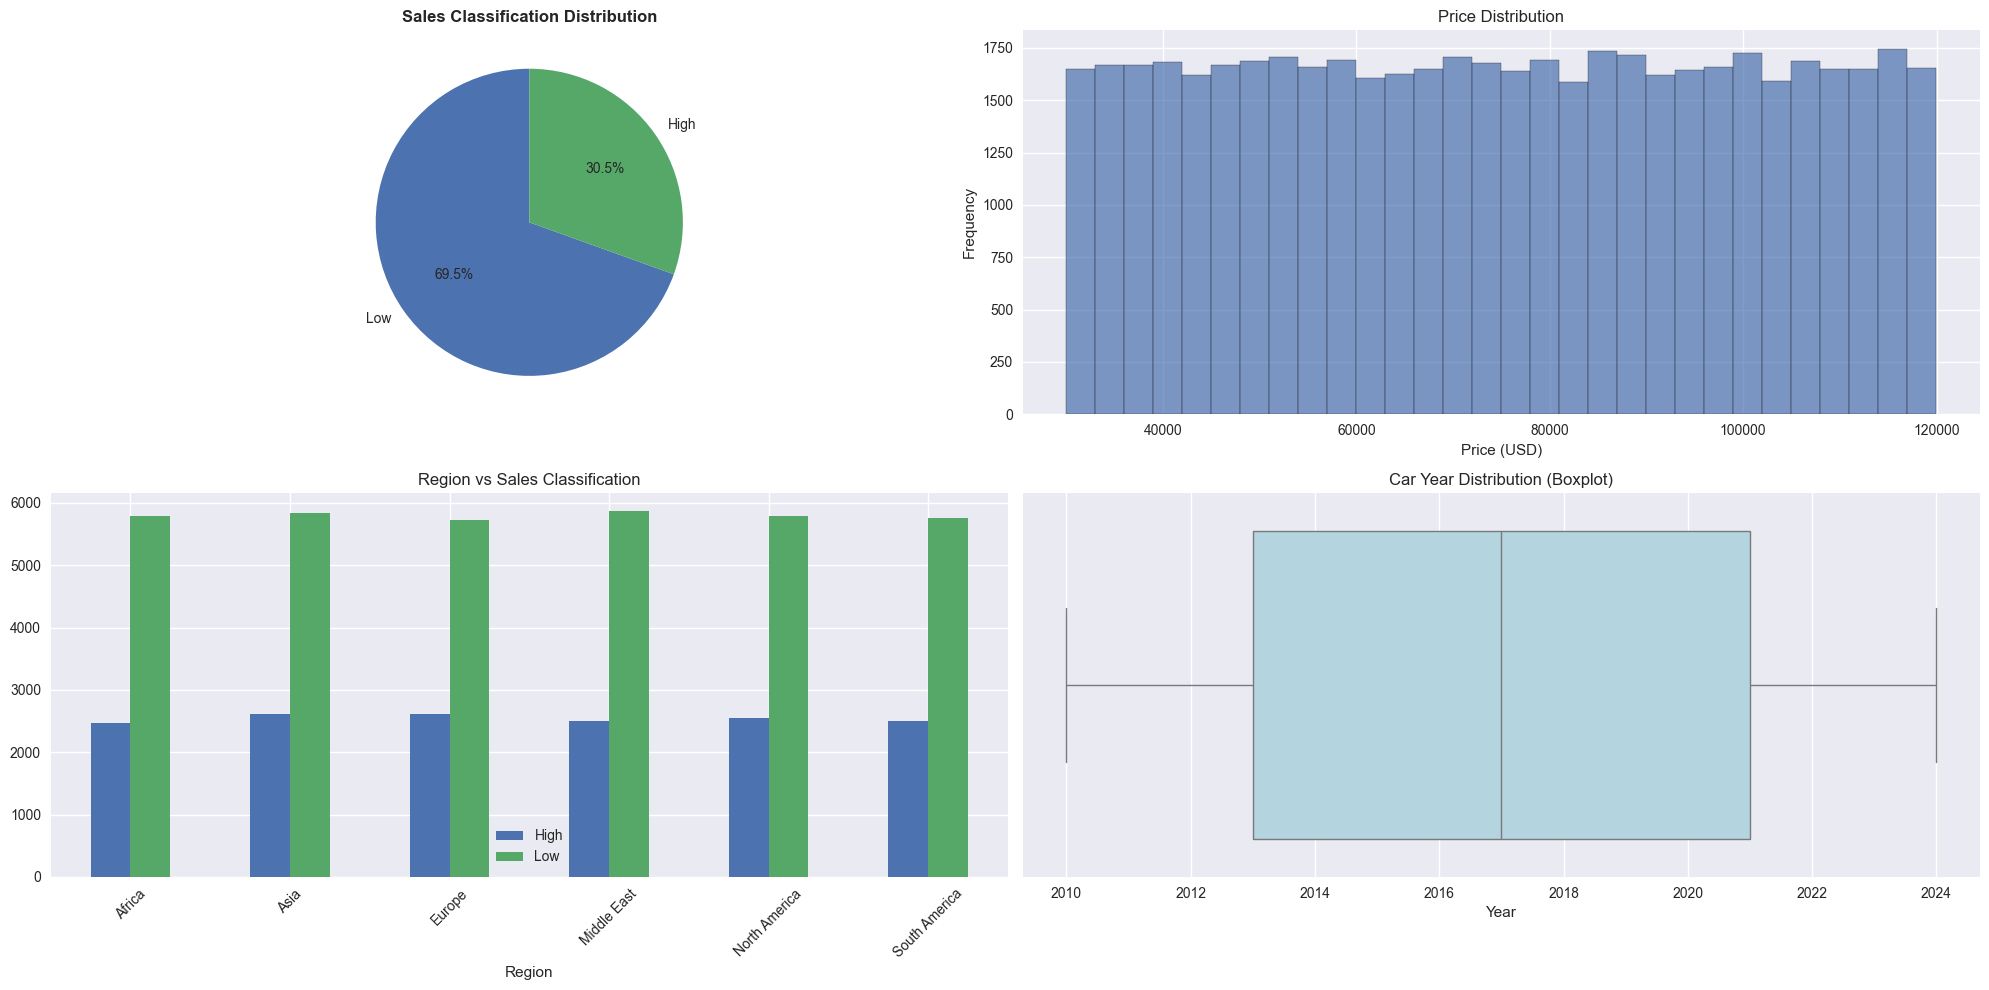

In [13]:
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes[0,0].pie(target_counts.values, labels = target_counts.index, autopct='%1.1f%%', startangle = 90)
axes[0,0].set_title('Sales Classification Distribution', fontweight = 'bold')

axes[0,1].hist(df['Price_USD'], bins = 30, alpha=0.7, edgecolor = 'black')
axes[0,1].set_title('Price Distribution')
axes[0,1].set_xlabel('Price (USD)')
axes[0,1].set_ylabel('Frequency')

region_sales = pd.crosstab(df['Region'], df['Sales_Classification'])
region_sales.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Region vs Sales Classification')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].legend(['High', 'Low'])

sns.boxplot(x=df['Year'], color='lightblue', ax=axes[1,1])
axes[1,1].set_title('Car Year Distribution (Boxplot)')
axes[1,1].set_xlabel('Year')

plt.tight_layout()
plt.show()

In [14]:
current_year = 2025
df['Car_Age'] = current_year - df['Year']
df['Price_Per_KM'] = df['Price_USD'] / (df['Mileage_KM'] + 1)
df['Engine_Power_Ratio'] = df['Engine_Size_L'] * df['Sales_Volume']

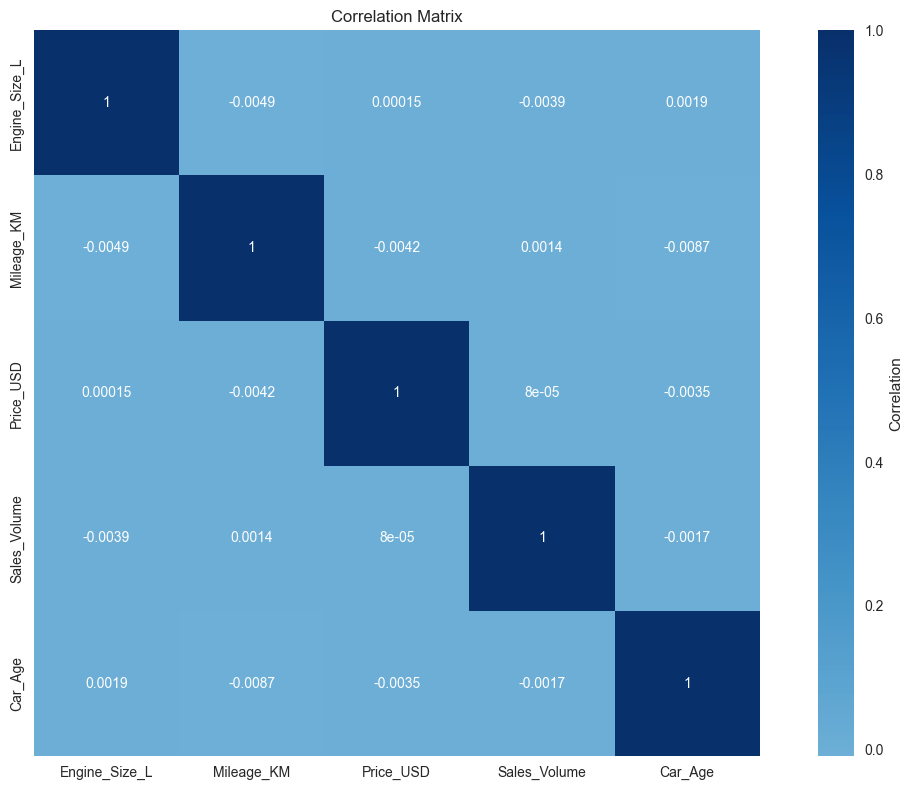

In [15]:
numeric_feature_vizual = ['Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume', 'Car_Age']
corr_matrix = df[numeric_feature_vizual].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', square=True, center=0, cbar_kws={'label':'Correlation'})
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [16]:
feature_columns = ['Model', 'Region', 'Color', 'Fuel_Type', 'Transmission', 
                   'Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume', 
                   'Car_Age', 'Price_Per_KM', 'Engine_Power_Ratio']

X = df[feature_columns]
y = df['Sales_Classification']


In [17]:
target_counts = y.value_counts(normalize=True) * 100
print(f"Balance:   High: {target_counts.get('High', 0):.1f}%, Low: {target_counts.get('Low', 0):.1f}%")

Balance:   High: 30.5%, Low: 69.5%


In [18]:
categorical_features = ['Model', 'Region', 'Color', 'Fuel_Type', 'Transmission']
numeric_features = ['Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume', 
                    'Car_Age', 'Price_Per_KM', 'Engine_Power_Ratio']


preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ]) 

In [19]:
base_models = {
    'RandomForestClassifier':RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, class_weight='balanced'),
    'LogisticRegression':LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'SVC':SVC(kernel='rbf', C=1.0, random_state=42, class_weight='balanced', probability=True),
    'GradientBoosting':GradientBoostingClassifier(random_state=42, max_depth=5, n_estimators=100, learning_rate=0.1)
}


ensemble_models = {
    'VotingHard':VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')),
            ('gb', GradientBoostingClassifier(random_state=42, n_estimators=50)),
            ('lr', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
        ], voting='hard'),

    'VotingSoft':VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(random_state=42, n_estimators=50, class_weight='balanced')),
            ('gb', GradientBoostingClassifier(random_state=42, n_estimators=50)),
            ('lr', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
        ], voting='soft'),

    'BaggingRF':BaggingClassifier(
        estimator=RandomForestClassifier(n_estimators=10, random_state=42), n_estimators=10, random_state=42, n_jobs=-1),

    'BaggingDT':BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42, class_weight='balanced'), n_estimators=20, random_state=42, n_jobs=-1),

    'AdaBoost':AdaBoostClassifier(
        estimator=RandomForestClassifier(n_estimators=10, random_state=42), n_estimators=50, learning_rate=1.0, random_state=42)
}

all_models = {**base_models, **ensemble_models}

In [20]:
cv = 5
skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

In [21]:
cv_results = {}
best_model_name = None
best_f1_score = -np.inf

for model_name, model in all_models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor), ('classifier', model)])
    
    cv_scores = cross_validate(pipeline, X, y, cv=skf, scoring=scoring_metrics, return_train_score=True, n_jobs=-1)

    cv_results[model_name] = cv_scores  

    test_scores = {}
    train_scores = {}

    for metric in scoring_metrics:
        test_key = f"test_{metric}"
        train_key = f"train_{metric}"

        test_scores[metric] = {
            'mean': cv_scores[test_key].mean(),
            'std': cv_scores[test_key].std()}

        train_scores[metric] = {
            'mean': cv_scores[train_key].mean(),
            'std': cv_scores[train_key].std()}
        
    print(f"{model_name}  ---> Cross-Validation Neticeleri")
    for metric in scoring_metrics:
        mean_score = test_scores[metric]['mean']
        std_score = test_scores[metric]['std']
        print(f"(Test Scores) {metric}:{mean_score:.4f} | {std_score*2:.4f}") # 95% lik interval

    for metric in scoring_metrics:
        mean_score = train_scores[metric]['mean']
        std_score = train_scores[metric]['std']
        print(f"(Train Score) {metric}:{mean_score:.4f} | {std_score*2:.4f}")


    # Overfitting yoxlamasi 
    train_f1 = train_scores['f1_weighted']['mean']
    test_f1 = test_scores['f1_weighted']['mean']
    overfitting = train_f1 - test_f1
    print(f"Overfitting (F1) ---> {overfitting:.4f}")
    print('-'*80)

    # En yaxsi modeli tapma
    if test_f1 > best_f1_score:
        best_f1_score = test_f1
        best_model_name = model_name

RandomForestClassifier  ---> Cross-Validation Neticeleri
(Test Scores) accuracy:1.0000 | 0.0002
(Test Scores) precision_weighted:1.0000 | 0.0002
(Test Scores) recall_weighted:1.0000 | 0.0002
(Test Scores) f1_weighted:1.0000 | 0.0002
(Train Score) accuracy:1.0000 | 0.0000
(Train Score) precision_weighted:1.0000 | 0.0000
(Train Score) recall_weighted:1.0000 | 0.0000
(Train Score) f1_weighted:1.0000 | 0.0000
Overfitting (F1) ---> 0.0000
--------------------------------------------------------------------------------
LogisticRegression  ---> Cross-Validation Neticeleri
(Test Scores) accuracy:0.9946 | 0.0015
(Test Scores) precision_weighted:0.9947 | 0.0014
(Test Scores) recall_weighted:0.9946 | 0.0015
(Test Scores) f1_weighted:0.9946 | 0.0014
(Train Score) accuracy:0.9948 | 0.0005
(Train Score) precision_weighted:0.9948 | 0.0004
(Train Score) recall_weighted:0.9948 | 0.0005
(Train Score) f1_weighted:0.9948 | 0.0005
Overfitting (F1) ---> 0.0002
-----------------------------------------------

In [22]:
print(f"Best Model ---> {best_model_name}")
print(f"F1 Score ---> {best_f1_score:.4f}")

Best Model ---> GradientBoosting
F1 Score ---> 1.0000


In [23]:
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', all_models[best_model_name])
])

In [24]:
y_pred = cross_val_predict(best_pipeline, X, y, cv=skf, method='predict')
y_pred_proba = cross_val_predict(best_pipeline, X, y, cv=skf, method='predict_proba')
cv_accuracy = accuracy_score(y, y_pred)
print(f"Accuracy : {cv_accuracy:.4f}")

Accuracy : 1.0000


In [25]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

        High       1.00      1.00      1.00     15246
         Low       1.00      1.00      1.00     34754

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000



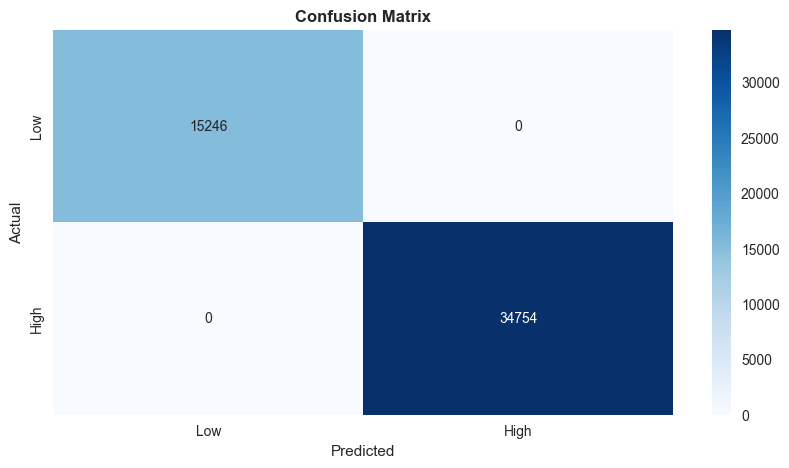

In [26]:
cm = confusion_matrix(y, y_pred)

# heatmap vizuali
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix", fontweight="bold")
plt.show()


In [27]:
comparison_data = []
for model_name in all_models.keys():
    for metric in scoring_metrics:
        test_scores = cv_results[model_name][f'test_{metric}']
        comparison_data.append({
            'Model': model_name,
            'Metric': metric,
            'Score': test_scores.mean(),
            'Std': test_scores.std(),
            'Type': 'Ensemble' if model_name in ensemble_models else 'Base'
        })

comparison_df = pd.DataFrame(comparison_data)


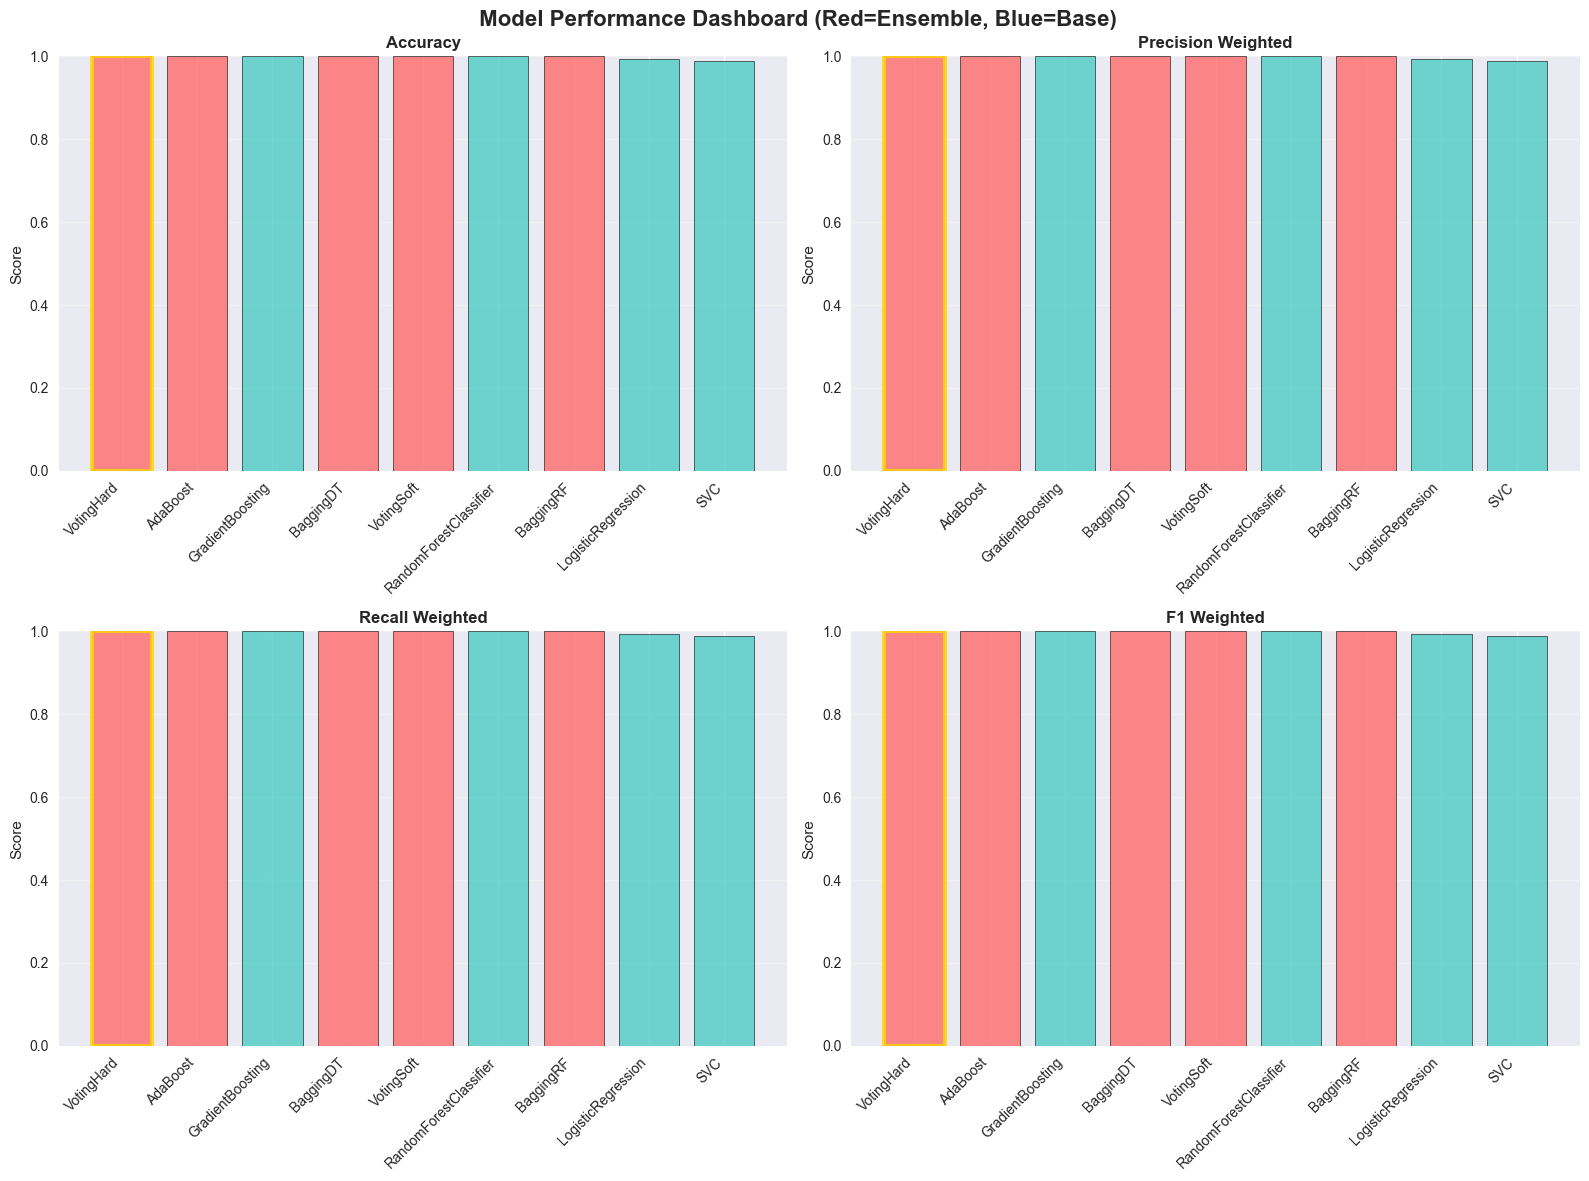

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = scoring_metrics

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    metric_data = comparison_df[comparison_df['Metric'] == metric].sort_values('Score', ascending=False)
    
    colors = ['#FF6B6B' if t == 'Ensemble' else '#4ECDC4' for t in metric_data['Type']]
    
    bars = ax.bar(range(len(metric_data)), metric_data['Score'], 
                  color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Best model highlight
    bars[0].set_edgecolor('gold')
    bars[0].set_linewidth(3)
    
    ax.set_title(f'{metric.replace("_", " ").title()}', fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_xticks(range(len(metric_data)))
    ax.set_xticklabels(metric_data['Model'], rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1)

plt.suptitle(' Model Performance Dashboard (Red=Ensemble, Blue=Base)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


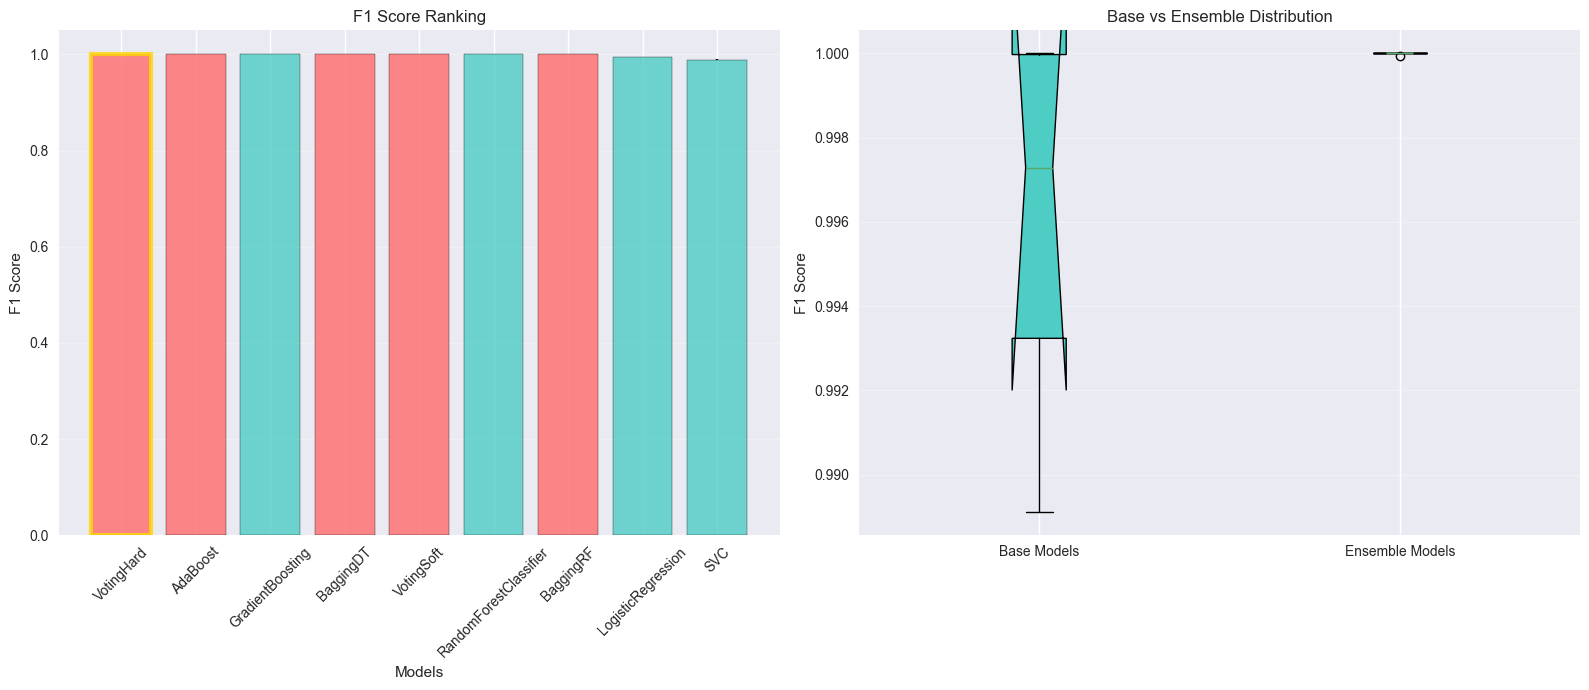

In [29]:
# F1 score ucun siralama
f1 = comparison_df[comparison_df['Metric']=='f1_weighted'].sort_values('Score', ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))

# Bar chart
colors = f1['Type'].map({'Base':'#4ECDC4', 'Ensemble':'#FF6B6B'})
bars = ax1.bar(f1['Model'], f1['Score'], yerr=f1['Std'], capsize=4, color=colors, edgecolor='black', alpha=0.8)
bars[0].set_edgecolor('gold')
bars[0].set_linewidth(3)

ax1.set(title='F1 Score Ranking', ylabel='F1 Score', xlabel='Models')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Box plot
box = ax2.boxplot([f1[f1['Type']=='Base']['Score'], f1[f1['Type']=='Ensemble']['Score']],
                  labels=['Base Models','Ensemble Models'], patch_artist=True, notch=True)

for patch, color in zip(box['boxes'], ['#4ECDC4','#FF6B6B']):
    patch.set_facecolor(color)

ax2.set(title='Base vs Ensemble Distribution', ylabel='F1 Score')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


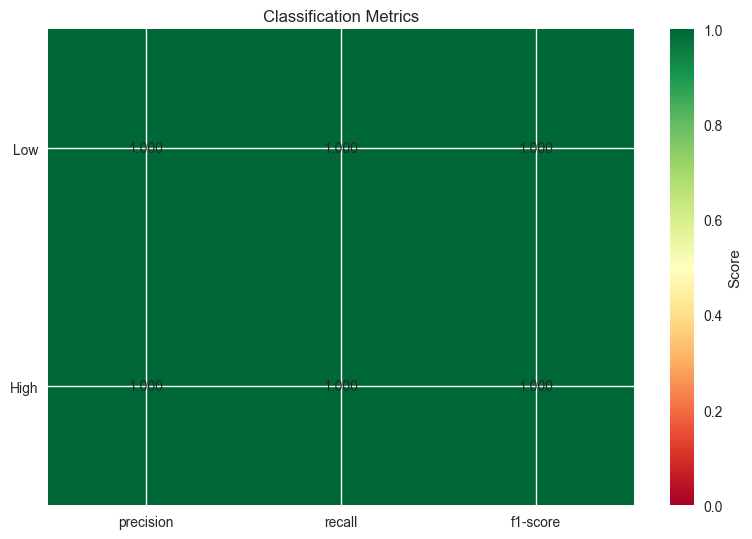

In [30]:
report = classification_report(y, y_pred, output_dict=True)

metrics = ['precision', 'recall', 'f1-score']
classes = ['Low', 'High']
scores = np.array([[report[cls][m] for m in metrics] for cls in classes])

plt.imshow(scores, cmap='RdYlGn', vmin=0, vmax=1, aspect='auto')
plt.xticks(range(len(metrics)), metrics)
plt.yticks(range(len(classes)), classes)

for i in range(scores.shape[0]):
    for j in range(scores.shape[1]):
        plt.text(j, i, f'{scores[i,j]:.3f}', ha='center', va='center')

plt.title('Classification Metrics')
plt.colorbar(label='Score')
plt.tight_layout()
plt.show()


Top  Feature Importance:
                 Feature    Importance
3           Sales_Volume  1.000000e+00
5           Price_Per_KM  1.016967e-13
6     Engine_Power_Ratio  4.846938e-14
1             Mileage_KM  2.523493e-14
2              Price_USD  1.180272e-15
30   Transmission_Manual  1.662323e-18
0          Engine_Size_L  0.000000e+00
7         Model_5 Series  0.000000e+00
8         Model_7 Series  0.000000e+00
9               Model_M3  0.000000e+00
10              Model_M5  0.000000e+00
11              Model_X1  0.000000e+00
12              Model_X3  0.000000e+00
13              Model_X5  0.000000e+00
4                Car_Age  0.000000e+00
14              Model_X6  0.000000e+00
15              Model_i3  0.000000e+00
17           Region_Asia  0.000000e+00
16              Model_i8  0.000000e+00
19    Region_Middle East  0.000000e+00
20  Region_North America  0.000000e+00
21  Region_South America  0.000000e+00
18         Region_Europe  0.000000e+00
22            Color_Blue  0.000000e+00


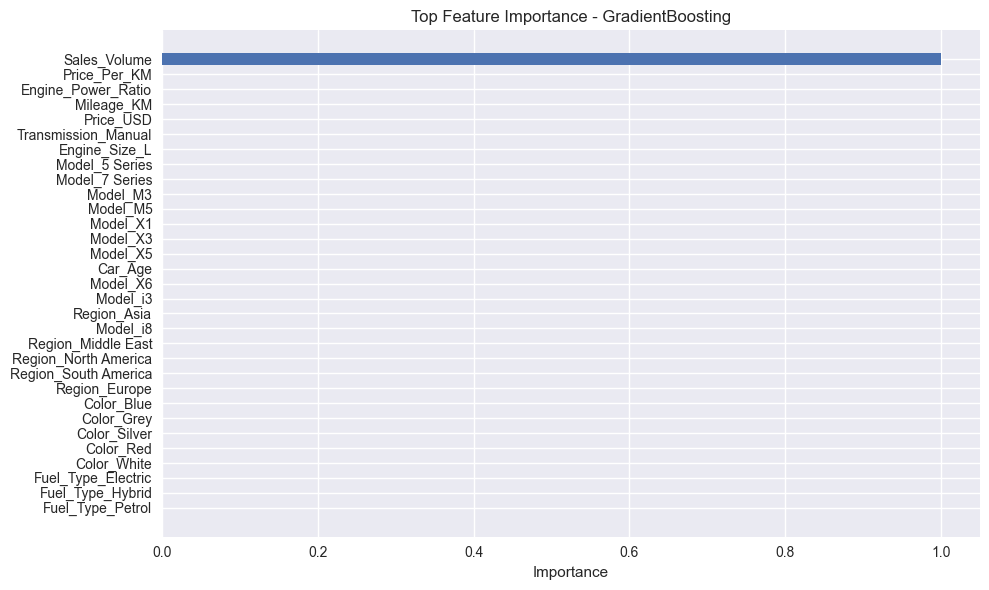

In [ ]:
# Feature importance yoxlama
classifier = best_pipeline.named_steps['classifier']

if hasattr(classifier, 'feature_importances_'):
    # Feature adlarını birləşdiririk
    num_feats = numeric_features
    cat_feats = best_pipeline.named_steps['preprocessor'] \
                .named_transformers_['cat'] \
                .get_feature_names_out(categorical_features)
    feature_names = list(num_feats) + list(cat_feats)

    # Feature importance
    importances = classifier.feature_importances_

    top = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print("Top Feature Importance:")
    print(top)

    plt.figure(figsize=(10, 6))
    plt.barh(top['Feature'], top['Importance'])
    plt.gca().invert_yaxis()
    plt.xlabel('Importance')
    plt.title(f'Top Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()


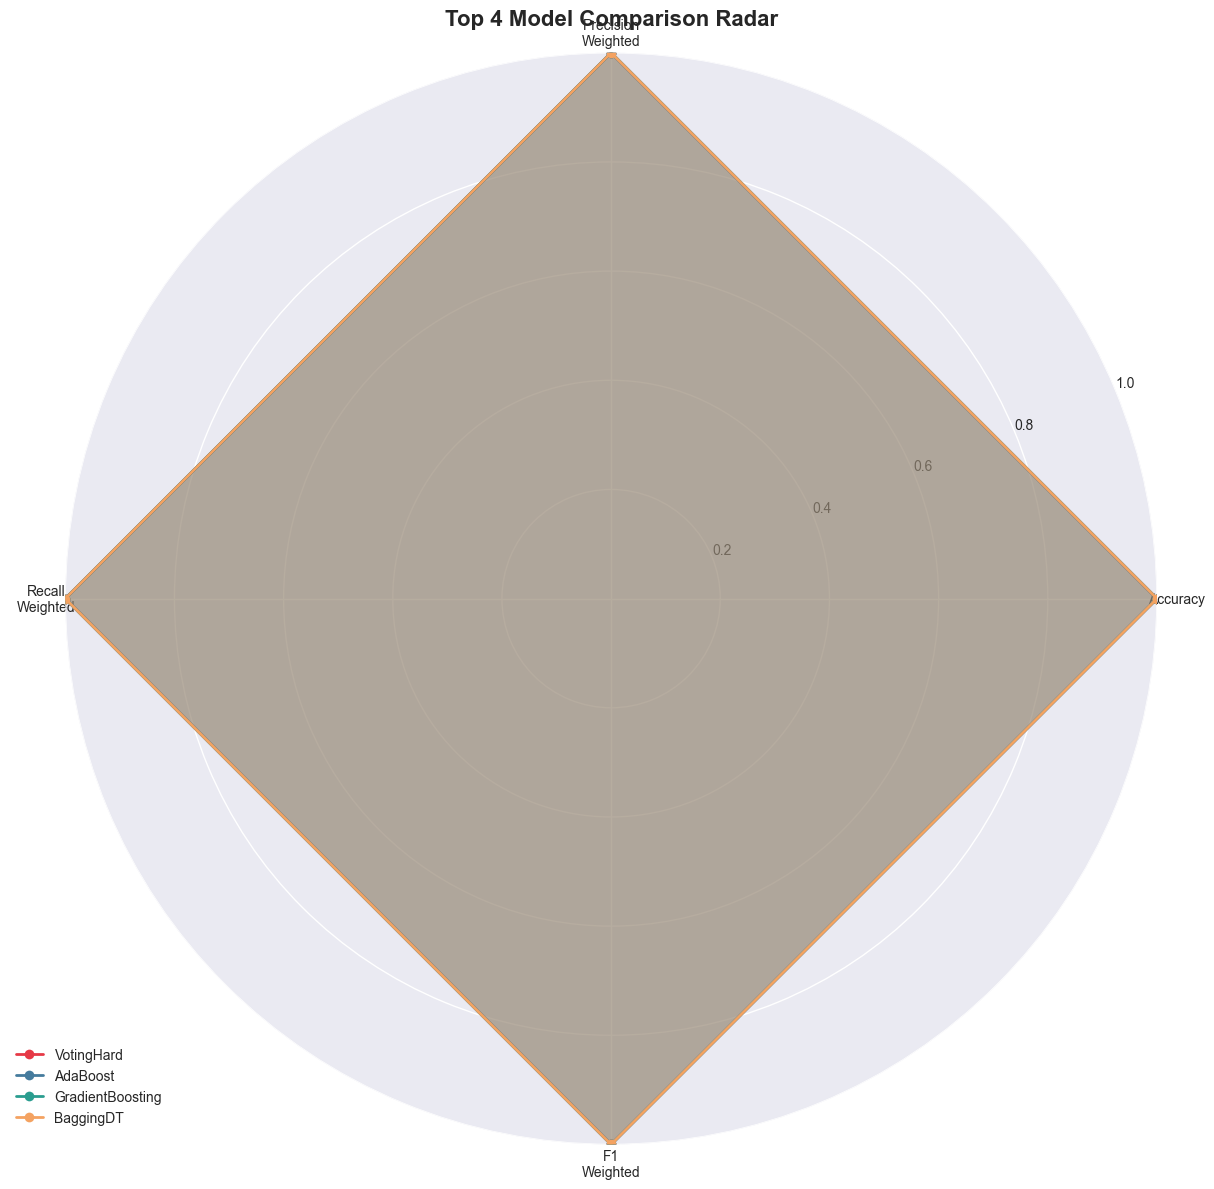

In [32]:
f1_comparison = comparison_df[comparison_df['Metric'] == 'f1_weighted'].sort_values('Score', ascending=False)

top_4_models = f1_comparison.head(4)['Model'].tolist()

fig, ax = plt.subplots(figsize=(16, 12), subplot_kw=dict(projection='polar'))

angles = np.linspace(0, 2 * np.pi, len(scoring_metrics), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

# Daha kontrast rənglər
colors = ['#E63946', '#457B9D', '#2A9D8F', 
          '#F4A261']  

for idx, model in enumerate(top_4_models):
    model_data = comparison_df[comparison_df['Model'] == model]
    scores = [model_data[model_data['Metric'] == metric]['Score'].iloc[0] for metric in scoring_metrics]
    scores += scores[:1]  # Complete the circle
    
    ax.plot(angles, scores, 'o-', linewidth=2, label=model, color=colors[idx])
    ax.fill(angles, scores, alpha=0.25, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels([metric.replace('_', '\n').title() for metric in scoring_metrics])
ax.set_ylim(0, 1)
ax.set_title('Top 4 Model Comparison Radar', fontweight='bold', fontsize=16, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
ax.grid(True)

plt.tight_layout()
plt.show()


In [33]:
best_pipeline.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Engine_Size_L',
                                                   'Mileage_KM', 'Price_USD',
                                                   'Sales_Volume', 'Car_Age',
                                                   'Price_Per_KM',
                                                   'Engine_Power_Ratio']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Model', 'Region', 'Color',
                                                   'Fuel_Type',
                                                   'Transmission'])])),
                ('classifier',
                 GradientBoostingClassifier(max_depth=5, random_state=42))])

In [ ]:
model_filename = 'bmw_class.pkl'
joblib.dump(best_pipeline, model_filename)
print("Ən yaxşı model (bmw_class) faylında saxlanıldı")

Ən yaxşı model (bmw_class) faylında saxlanıldı


# Prediction

#### Model : '5 Series', 'i8', 'X3', '7 Series', 'M5', '3 Series', 'X1', 'M3', 'X5', 'i3', 'X6'
#### Region : 'Asia', 'North America', 'Middle East', 'South America', 'Europe', 'Africa'
#### Color : 'Red', 'Blue', 'Black', 'Silver', 'White', 'Grey'
#### Fuel Type : 'Petrol', 'Hybrid', 'Diesel', 'Electric'
#### Transmission : 'Manual', 'Automatic'

In [38]:
loaded_model = joblib.load('bmw_class.pkl')

In [44]:
print("Single Prediction Example")
print("="*40)

new_data = pd.DataFrame({
    'Model': ['X1'],
    'Region': ['North America'],
    'Color': ['Grey'],
    'Fuel_Type': ['Electric'],
    'Transmission': ['Automatic'],
    'Engine_Size_L': [3.40],
    'Mileage_KM': [3000],
    'Price_USD': [78000],
    'Sales_Volume': [100],
    'Car_Age': [2],
    'Price_Per_KM': [3.0],
    'Engine_Power_Ratio': [240.0]
})

new_data = new_data[feature_columns]
prediction = loaded_model.predict(new_data)
prediction_proba = loaded_model.predict_proba(new_data)

print(f"Predicted Class: {prediction[0]}")

# Sinif ehtimalları modelin öz sırasına görə
for cls, prob in zip(loaded_model.classes_, prediction_proba[0]):
    print(f"Probability for '{cls}': {prob:.3f}")


Single Prediction Example
Predicted Class: Low
Probability for 'High': 0.000
Probability for 'Low': 1.000


In [ ]:
print("\nBatch Prediction Example")
print("="*40)

batch_data = pd.DataFrame({
    'Model': ['X5', '3 Series'],
    'Region': ['West', 'East'],
    'Color': ['Black', 'White'],
    'Fuel_Type': ['Petrol', 'Diesel'],
    'Transmission': ['Automatic', 'Manual'],
    'Engine_Size_L': [3.0, 2.0],
    'Mileage_KM': [15000, 25000],
    'Price_USD': [45000, 35000],
    'Sales_Volume': [80, 120],
    'Car_Age': [3, 2],
    'Price_Per_KM': [3.0, 1.4],
    'Engine_Power_Ratio': [240.0, 240.0]
})

batch_data = batch_data[feature_columns]
batch_predictions = loaded_model.predict(batch_data)
batch_probabilities = loaded_model.predict_proba(batch_data)

for i, (pred, prob) in enumerate(zip(batch_predictions, batch_probabilities)):
    print(f"\nCar {i+1}:")
    print(f"  Predicted Class: {pred}")
    for cls, p in zip(loaded_model.classes_, prob):
        print(f"  Probability for '{cls}': {p:.3f}")



Batch Prediction Example

Car 1:
  Predicted Class: Low
  Probability for 'High': 0.000
  Probability for 'Low': 1.000

Car 2:
  Predicted Class: Low
  Probability for 'High': 0.000
  Probability for 'Low': 1.000
